<a href="https://colab.research.google.com/github/fluderm/PyBulletPerAct/blob/main/PyBulletPerAct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyBulletPerAct:** 

The following notebook implements the PerAct training pipeline. It requires saved data (you can download examples of pick and place from my google drive -- see below). In order to generate your own data, run the [Create_and_save_demo](https://github.com/fellowship/Robotics-Simulator-Imitation-Learning/blob/main/Create_and_save_demo.ipynb) notebook.

A lot of the following is code adapted from:

*   [Perceiver-Actor (PerAct)](https://github.com/peract/peract) -- see also the relevant [paper](https://peract.github.io/) and the [colab](https://colab.research.google.com/drive/1wpaosDS94S0rmtGmdnP0J1TjS7mEM14V?usp=sharing)
*   [`ARM`](https://github.com/stepjam/ARM) 
*   [`YARR`](https://github.com/stepjam/YARR)
*   [`PyRep`](https://github.com/stepjam/PyRep)
*   [`RLBench`](https://github.com/stepjam/RLBench) see also the [paper](https://stepjam.github.io/) 
*   [PerceiverIO](https://arxiv.org/abs/2107.14795) from [`perceiver-pytorch`](https://github.com/lucidrains/perceiver-pytorch) 
*   [this LAMB implementation](https://github.com/cybertronai/pytorch-lamb).






### Install Dependencies

In [ ]:
!pip install scipy==1.4.1 ftfy regex tqdm torch==1.7.1 git+https://github.com/openai/CLIP.git einops pyrender==0.1.45 trimesh==3.9.34 pycollada==0.6

In [ ]:
%pip install setuptools==65.5.0 # Need to add this for panda-gym==2.0.0 to work
!apt install -y python-opengl ffmpeg > /dev/null 2>&1
%pip install pyvirtualdisplay

#stable_baselines3 sb3_contrib panda-gym==2.0.0 
!pip install pyvirtualdisplay 
!apt install xvfb python-opengl ffmpeg

### Clone Repos and Setup




In [ ]:
!git clone https://github.com/peract/peract_colab.git

If you fork-off this repo, you might want to pull the latest changes.

In [ ]:
!cd peract_colab && git pull origin master

In [ ]:
!git clone https://github.com/fluderm/PyBulletPerAct.git
%pip install -e PyBulletPerAct

# copy glass files to current directory:

!cp PyBulletPerAct/panda_gym/plastic_coffee_cup.mtl \
 PyBulletPerAct/panda_gym/plastic_coffee_cup_vhacd.obj \
 PyBulletPerAct/panda_gym/plastic_coffee_cup.obj .

### Download data

Let us download some data

In [ ]:
''' 
Fetch pick_and_place data generated in create_and_save and saved on my google
drive as a zip file
'''

!gdown 1YQOpEDCtGUgDgE6FiK-hpd2ON4y9O39S

In [ ]:
# unzip data to current directory

!unzip data_pnp.zip -d Robotics-Simulator-Imitation-Learning/PyBulletPerAct-main/pnp

# Panda Gym

Importing panda gym is technically not necessary, but it is used to check a variety of things below.



In [ ]:
import sys
import os
import pickle
from PIL import Image
#from absl import app
#from absl import flags

sys.path.append('PyBulletPerAct')
sys.path.append('peract_colab')

In [ ]:
import gym
import panda_gym
import pprint
import numpy as np
import pybullet as p
import math
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1024, 768))
display.start()

from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

'''
The following are some basic functions that help render the virtual PyBullet
environment:
'''

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

class trigger:
    def __init__(self):
        self._trigger = True

    def __call__(self, e):
        return self._trigger

    def set(self, t):
        self._trigger = t

In [ ]:
# quick check if everything works:
env = gym.make('PandaPickAndPlace-v2',control_type='joints')
obs = env.reset()
env.robot.neutral_joint_values = np.array([0.00, 0.41, 0.00, -1.85, 3.14, 2.52, 0.79, 3.00, 3.00])
print(obs)

## Some Utils

We define some utils. Mostly copies of functions defined in [Create_and_save_demo](https://github.com/fellowship/Robotics-Simulator-Imitation-Learning/blob/main/Create_and_save_demo.ipynb)

In [ ]:
panda_dataset_dir = 'PyBulletPerAct/pnp/PyBulletPerAct/data'

def check_and_make(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

check_and_make(panda_dataset_dir)

In [ ]:
import datetime as dt
from time import sleep

def no_disconnect():
  t = dt.datetime.now()
  '''
  function that ensures Colab pro doesn't disconnect.
  '''
  while True:
      delta = dt.datetime.now()-t               
      if delta.seconds >= 60:
          print("1 Min",dt.datetime.now())
          t = dt.datetime.now()
      sleep(10)

In [ ]:
def _normalize(pc):
  return (pc - np.amin(pc)) / (np.amax(pc) - np.amin(pc))

In [ ]:
def ClipFloatValues(float_array, min_value, max_value):
  '''
  Clips values to the range [min_value, max_value].
  First checks if any values are out of range and prints a message.
  Then clips all values to the given range.
  Args:
    float_array: 2D array of floating point values to be clipped.
    min_value: Minimum value of clip range.
    max_value: Maximum value of clip range.
  Returns:
    The clipped array.
  '''
  if float_array.min() < min_value or float_array.max() > max_value:
    float_array = np.clip(float_array, min_value, max_value)
  return float_array

DEFAULT_RGB_SCALE_FACTOR = 256000.0

def float_array_to_rgb_image(float_array,
                             scale_factor=DEFAULT_RGB_SCALE_FACTOR,
                             drop_blue=False):
  '''
  Convert a floating point array of values to an RGB image.
  Convert floating point values to a fixed point representation where
  the RGB bytes represent a 24-bit integer.
  R is the high order byte.
  B is the low order byte.
  The precision of the depth image is 1/256 mm.
  Floating point values are scaled so that the integer values cover
  the representable range of depths.
  This image representation should only use lossless compression.
  Args:
    float_array: Input array of floating point depth values in meters.
    scale_factor: Scale value applied to all float values.
    drop_blue: Zero out the blue channel to improve compression, results in 1mm
      precision depth values.
  Returns:
    24-bit RGB PIL Image object representing depth values.
  '''
  # Scale the floating point array.
  scaled_array = np.floor(float_array * scale_factor + 0.5)

  # Convert the array to integer type and clip to representable range.
  min_inttype = 0
  max_inttype = 2**24 - 1
  scaled_array = ClipFloatValues(scaled_array, min_inttype, max_inttype)
  int_array = scaled_array.astype(np.uint32)
  # Calculate:
  #   r = (f / 256) / 256  high byte
  #   g = (f / 256) % 256  middle byte
  #   b = f % 256          low byte
  rg = np.divide(int_array, 256)
  r = np.divide(rg, 256)
  g = np.mod(rg, 256)
  image_shape = int_array.shape
  rgb_array = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
  rgb_array[..., 0] = r
  rgb_array[..., 1] = g
  if not drop_blue:
    # Calculate the blue channel and add it to the array.
    b = np.mod(int_array, 256)
    rgb_array[..., 2] = b
  image_mode = 'RGB'
  image = Image.fromarray(rgb_array, mode=image_mode)
  return image

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot

def cvK2BulletP(K, w, h, near, far):
    '''
    cvKtoPulletP converts the K interinsic matrix as calibrated using Opencv
    and ROS to the projection matrix used in openGL and Pybullet.

    :param K:  OpenCV 3x3 camera intrinsic matrix
    :param w:  Image width
    :param h:  Image height
    :near:     The nearest objects to be included in the render
    :far:      The furthest objects to be included in the render
    :return:   4x4 projection matrix as used in openGL and pybullet
    '''
    f_x = K[0,0]
    f_y = K[1,1]
    c_x = K[0,2]
    c_y = K[1,2]
    A = (near + far)/(near - far)
    B = 2 * near * far / (near - far)

    projection_matrix = [
                        [2/w * f_x,  0,          (w - 2*c_x)/w,  0],
                        [0,          2/h * f_y,  (2*c_y - h)/h,  0],
                        [0,          0,          A,              B],
                        [0,          0,          -1,             0]]
    # The transpose is needed for respecting the array structure of the PyB
    # and OpenGL
    return np.array(projection_matrix).T.reshape(16).tolist()

def BulletP2cvK(proj_mat, w, h):
    '''
    inverse of above cvK2BulletP function
    '''
    A,B = proj_mat[2,2],proj_mat[3,2]
    n,f = B/(A-1), B/(A+1)
    fx,fy = w*proj_mat[0,0]/2,h*proj_mat[1,1]/2
    cx,cy = w*(1-proj_mat[2,0])/2, h*(proj_mat[2,1]+1)/2

    return np.array([[fx,0,cx],[0,fy,cy],[0,0,1]]), n, f


def cvPose2BulletView(Rt):
    '''
    cvPose2BulletView gets orientation and position as used 
    in ROS-TF and opencv and coverts it to the view matrix used 
    in openGL and pyBullet.
    
    :param Rt: 4x4 extrinsic matrix
    :return:  4x4 view matrix as used in PyBullet and openGL
    
    '''

    Tc = np.array([[1,   0,    0,  0],
                   [0,  -1,    0,  0],
                   [0,   0,   -1,  0],
                   [0,   0,    0,  1]]).reshape(4,4)
    
    # pybullet pse is the inverse of the pose from the ROS-TF
    T=Tc@np.linalg.inv(Rt)
    # The transpose is needed for respecting the array structure of the OpenGL
    viewMatrix = T.T.reshape(16)
    return viewMatrix

def BullettocvPose(X):
    '''
    Inverse function of cvPose2BulletView, i.e. returns extrinsic matrix from
    PyBullet/OpenGL.
    '''
    Tc = np.array([[1,   0,    0,  0],
                   [0,  -1,    0,  0],
                   [0,   0,   -1,  0],
                   [0,   0,    0,  1]]).reshape(4,4)
    
    T = np.linalg.inv(X.T)@Tc
    
    return T

In [ ]:
# import Demo, Observation and ObservationElement classes 
# (see e.g. Create_and_save_demo)

from rlbench.demo import Demo
from rlbench.backend.observation import Observation
from yarr.utils.observation_type import ObservationElement

In [ ]:
def _normalize_fn(pc,far,near):
  return (pc-near)/(far-near)

In [ ]:
IMAGE_FORMAT = '%d.png'

LEFT_SHOULDER_RGB_FOLDER = 'left_shoulder_rgb'
LEFT_SHOULDER_DEPTH_FOLDER = 'left_shoulder_depth'
LEFT_SHOULDER_MASK_FOLDER = 'left_shoulder_mask'
RIGHT_SHOULDER_RGB_FOLDER = 'right_shoulder_rgb'
RIGHT_SHOULDER_DEPTH_FOLDER = 'right_shoulder_depth'
RIGHT_SHOULDER_MASK_FOLDER = 'right_shoulder_mask'
OVERHEAD_RGB_FOLDER = 'overhead_rgb'
OVERHEAD_DEPTH_FOLDER = 'overhead_depth'
OVERHEAD_MASK_FOLDER = 'overhead_mask'
WRIST_RGB_FOLDER = 'wrist_rgb'
WRIST_DEPTH_FOLDER = 'wrist_depth'
WRIST_MASK_FOLDER = 'wrist_mask'
FRONT_RGB_FOLDER = 'front_rgb'
FRONT_DEPTH_FOLDER = 'front_depth'
FRONT_MASK_FOLDER = 'front_mask'
EPISODES_FOLDER = 'episodes'
EPISODE_FOLDER = 'episode%d'
VARIATIONS_FOLDER = 'variation%d'

LOW_DIM_PICKLE = 'low_dim_obs.pkl'
VARIATION_DESCRIPTIONS = 'variation_descriptions.pkl'

DEPTH_SCALE = 2**24 - 1

# PerAct

In [ ]:
import numpy as np
import os
import sys
import shutil
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl" 

In [ ]:
# constants
TASK = 'pick and place'
DATA_FOLDER ='PyBulletPerAct/'
EPISODES_FOLDER = 'pnp/PyBulletPerAct/data'
EPISODE_FOLDER = 'episode%d'
CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
LOW_DIM_SIZE = 4   # {left_finger_joint, right_finger_joint, gripper_open, timestep}
IMAGE_SIZE =  128  # 128x128 - if you want to use higher voxel resolutions like 200^3, you might want to regenerate the dataset with larger images

# in my data we do not have variation_descriptions.pkl, this is something that should be implemented.
# there are some details in the Create_and_save file.
VARIATION_DESCRIPTIONS_PKL = 'variation_descriptions.pkl' # the pkl file that contains language goals for each demonstration
EPISODE_LENGTH = 10 # max steps for agents
DEMO_AUGMENTATION_EVERY_N = 10 # sample n-th frame in demo
ROTATION_RESOLUTION = 5 # degree increments per axis

# settings
VOXEL_SIZES = [100] # 100x100x100 voxels
NUM_LATENTS = 512 # PerceiverIO latents

# I would suggest potentially optimizing th scene_bounds to have less empty space.
SCENE_BOUNDS = [-0.5, -0.5, 0.0, 0.5, 0.5, 1.0] #the metric volume to be voxelized

BATCH_SIZE = 1 
NUM_DEMOS = 15 # total number of training demonstrations to use while training PerAct
NUM_TEST = 5 # episodes to evaluate on

In [ ]:
data_path = os.path.join(DATA_FOLDER, EPISODES_FOLDER)

train_replay_storage_dir = 'replay_train'
if not os.path.exists(train_replay_storage_dir):
  os.mkdir(train_replay_storage_dir)

test_replay_storage_dir = 'replay_test'
if not os.path.exists(test_replay_storage_dir):
  os.mkdir(test_replay_storage_dir)

## Data Loading & Preprocessing

An expert demonstration recorded at ~20Hz contains 100s of individual timesteps in a sequence. Each timestep contains observations recorded from 4 calibrated cameras (front, left_shoulder, right_shoulder, and wrist) and other proprioception sensors. "Calibrated" means we know the extrinsics and intrinsics. 

### Load Demo

We now define functions that implement loading demos stored using [Create_and_save_demo](https://github.com/fellowship/Robotics-Simulator-Imitation-Learning/blob/main/Create_and_save_demo.ipynb)

In [ ]:
import PIL.Image

EPISODE_FOLDER = 'episode%d'

CAMERA_FRONT = 'front'
CAMERA_LS = 'left_shoulder'
CAMERA_RS = 'right_shoulder'
CAMERA_WRIST = 'wrist'
CAMERAS = [CAMERA_FRONT, CAMERA_LS, CAMERA_RS, CAMERA_WRIST]

IMAGE_RGB = 'rgb'
IMAGE_DEPTH = 'depth'
IMAGE_TYPES = [IMAGE_RGB, IMAGE_DEPTH]
IMAGE_FORMAT  = '%d.png'
LOW_DIM_PICKLE = 'low_dim_obs.pkl'
VARIATION_NUMBER_PICKLE = 'variation_number.pkl'

DEPTH_SCALE = 2**24 - 1

index = 1
episode_path = os.path.join(data_path, EPISODE_FOLDER % index)

DEFAULT_RGB_SCALE_FACTOR = 256000.0

DEFAULT_GRAY_SCALE_FACTOR = {np.uint8: 100.0,
                             np.uint16: 1000.0,
                             np.int32: DEFAULT_RGB_SCALE_FACTOR}


def image_to_float_array(image, scale_factor=None):
  '''
  Converts image to float array (inverse of float_array_to_rgb_image)
  Args:
    :image: rgb image stored using float_array_to_rgb_image
    :scale_factor: scale image
  Returns:
    np.array of rgb image.
  '''
  image_array = np.array(image)
  image_dtype = image_array.dtype
  image_shape = image_array.shape

  channels = image_shape[2] if len(image_shape) > 2 else 1
  assert 2 <= len(image_shape) <= 3
  if channels == 3:
    # RGB image needs to be converted to 24 bit integer.
    float_array = np.sum(image_array * [65536, 256, 1], axis=2)
    if scale_factor is None:
      scale_factor = DEFAULT_RGB_SCALE_FACTOR
  else:
    if scale_factor is None:
      scale_factor = DEFAULT_GRAY_SCALE_FACTOR[image_dtype.type]
    float_array = image_array.astype(np.float32)
  scaled_array = float_array / scale_factor
  return scaled_array



import os
import pickle
import numpy as np
from PIL import Image

from pyrep.objects import VisionSensor

# constants
EPISODE_FOLDER = 'episode%d'

CAMERA_FRONT = 'front'
CAMERA_LS = 'left_shoulder'
CAMERA_RS = 'right_shoulder'
CAMERA_WRIST = 'wrist'
CAMERAS = [CAMERA_FRONT, CAMERA_LS, CAMERA_RS, CAMERA_WRIST]

IMAGE_RGB = 'rgb'
IMAGE_DEPTH = 'depth'
IMAGE_TYPES = [IMAGE_RGB, IMAGE_DEPTH]
IMAGE_FORMAT  = '%d.png'
LOW_DIM_PICKLE = 'low_dim_obs.pkl'
VARIATION_NUMBER_PICKLE = 'variation_number.pkl'

DEPTH_SCALE = 2**24 - 1

# functions
def get_stored_demo(data_path, index):
  '''
  function that loads demos from data_path and index as stored in the 
  conventions of Create_and_save_demo.
  Args:
    :data_path: path where data is stored
    :index: specific episode to be loaded
  
  Returns:
    demo stored as a list of Observations.
  '''
  episode_path = os.path.join(data_path, EPISODE_FOLDER % index)
  
  # low dim pickle file
  with open(os.path.join(episode_path, LOW_DIM_PICKLE), 'rb') as f:
    obs = pickle.load(f)

  # variation number: if you want to load a text prompt associated with a demo,
  # uncomment the following lines and modify Create_and_save_demo accordingly.
  # with open(os.path.join(episode_path, VARIATION_NUMBER_PICKLE), 'rb') as f:
  #  obs.variation_number = pickle.load(f)

  obs.variation_number = 1
  
  num_steps = len(obs)
  for i in range(num_steps):
    obs[i].front_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_RGB), IMAGE_FORMAT % i)).convert('RGB'))
    obs[i].left_shoulder_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_RGB), IMAGE_FORMAT % i)).convert('RGB'))
    obs[i].right_shoulder_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_RGB), IMAGE_FORMAT % i)).convert('RGB'))
    obs[i].wrist_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_RGB), IMAGE_FORMAT % i)).convert('RGB'))

    obs[i].front_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_FRONT)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_FRONT)]
    obs[i].front_depth = near + obs[i].front_depth * (far - near)

    obs[i].left_shoulder_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_LS)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_LS)]
    obs[i].left_shoulder_depth = near + obs[i].left_shoulder_depth * (far - near)

    obs[i].right_shoulder_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_RS)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_RS)]
    obs[i].right_shoulder_depth = near + obs[i].right_shoulder_depth * (far - near)

    obs[i].wrist_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_WRIST)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_WRIST)]
    obs[i].wrist_depth = near + obs[i].wrist_depth * (far - near)

    obs[i].front_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].front_depth, 
                                                                                    obs[i].misc['front_camera_extrinsics'],
                                                                                    obs[i].misc['front_camera_intrinsics'])
    obs[i].left_shoulder_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].left_shoulder_depth, 
                                                                                            obs[i].misc['left_shoulder_camera_extrinsics'],
                                                                                            obs[i].misc['left_shoulder_camera_intrinsics'])
    obs[i].right_shoulder_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].right_shoulder_depth, 
                                                                                             obs[i].misc['right_shoulder_camera_extrinsics'],
                                                                                             obs[i].misc['right_shoulder_camera_intrinsics'])
    obs[i].wrist_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].wrist_depth, 
                                                                                           obs[i].misc['wrist_camera_extrinsics'],
                                                                                           obs[i].misc['wrist_camera_intrinsics'])
    
  return obs

In [ ]:
# Below is a way to get the point clouds from camera intrinsics/extrinsics in PyBullet
# Not necessary for the following but I think it's worth keeping for people
# to understand point clouds.
# import pybullet as p
# def get_point_cloud_from_Pybullet(width, height, view_matrix, proj_matrix):
#     image_arr = p.getCameraImage(width=width, height=height, viewMatrix=view_matrix, projectionMatrix=proj_matrix)
#     depth = image_arr[3]
#     proj_matrix = np.asarray(proj_matrix).reshape([4, 4], order="F")
#     view_matrix = np.asarray(view_matrix).reshape([4, 4], order="F")
#     tran_pix_world = np.linalg.inv(np.matmul(proj_matrix, view_matrix))
#     y, x = np.mgrid[-1:1:2 / height, -1:1:2 / width]
#     y *= -1.
#     x, y, z = x.reshape(-1), y.reshape(-1), depth.reshape(-1)
#     h = np.ones_like(z)
#     pixels = pixels[z < 0.99]
#     pixels[:, 2] = 2 * pixels[:, 2] - 1
#     points = np.matmul(tran_pix_world, pixels.T).T
#     points /= points[:, 3: 4]
#     points = points[:, :3]
#     return points

#### Some Tests

Some basic tests to see whether demo import worked.

Demo 1 | 172 total steps



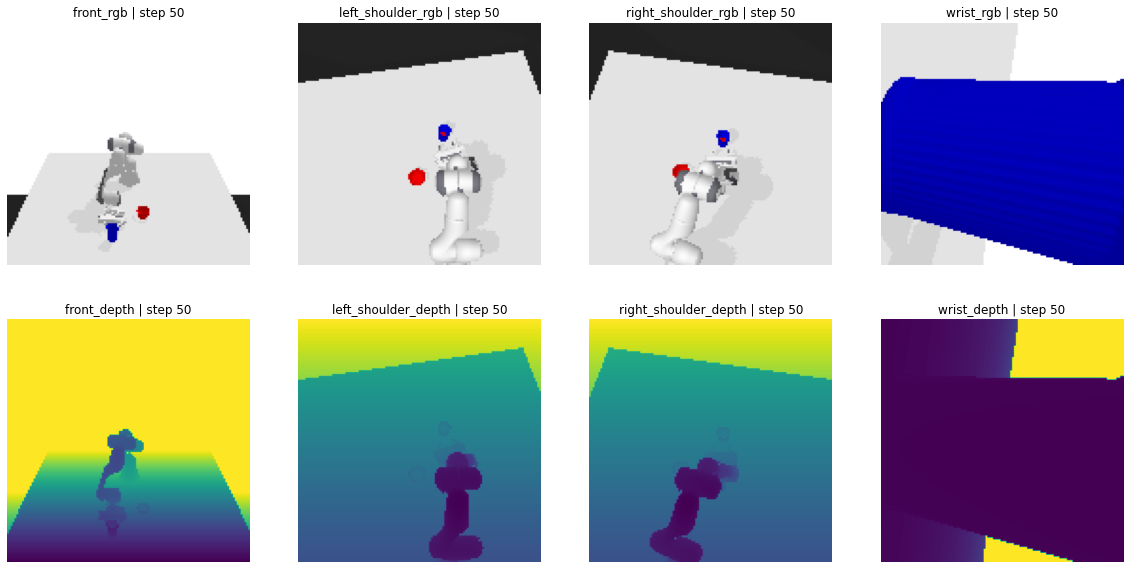

In [ ]:
#from rlbench.utils import get_stored_demo
from rlbench.backend.utils import extract_obs

# what to visualize
episode_idx_to_visualize = 1 # out of 10 demos
ts = 50 # timestep out of total timesteps

# get demo
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)     

# extract obs at timestep                 
obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)

# total timesteps in demo
print(f"Demo {episode_idx_to_visualize} | {len(demo._observations)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(CAMERAS)

plot_idx = 1
for camera in CAMERAS:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

In [ ]:
# Visualize demo 9 from wrist camera.

episode_idx_to_visualize = 9
demo_peract = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)     

# total timesteps
print("Demo %s | %s total steps" % (episode_idx_to_visualize, len(demo._observations))) 

# use the heuristic to extract keyframes (aka keypoints)
#episode_keypoints = _keypoint_discovery(demo)


ff=[]
for kp in range(len(demo_peract._observations)):
  obs_dict = extract_obs(demo_peract._observations[kp], CAMERAS, t=kp)
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  ff.append(rgb)

Demo 9 | 172 total steps


In [ ]:
# animate:

display.HTML(display_anim(ff))

In [ ]:
# Visualize demo 1 from front camera.

episode_idx_to_visualize = 1
demo = get_stored_demo(data_path=panda_dataset_dir,
                      index=1)     

# total timesteps
print("Demo %s | %s total steps" % (episode_idx_to_visualize, len(demo._observations))) 

# use the heuristic to extract keyframes (aka keypoints)
#episode_keypoints = _keypoint_discovery(demo)


ff=[]
for kp in range(len(demo._observations)):
  obs_dict = extract_obs(demo._observations[kp], CAMERAS, t=kp)
  rgb = np.transpose(obs_dict['front_rgb'], (1, 2, 0))
  ff.append(rgb)

Demo 1 | 172 total steps


In [ ]:
# animate:
display.HTML(display_anim(ff))

Basic check of whether the point cloud has been properly loaded:

The picture below is supposed to show the intersection of the point cloud with the surfaces {x=0}, {y=0} and {z=0}.

In [ ]:
obs = env.reset()
rgb, depth, mask, misc = env.render(mode = 'rgb_array', width = 128, height = 128)

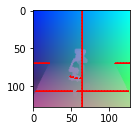

In [ ]:
dpi,fps=72,50
test_pc = demo._observations[10].front_point_cloud

y,x,_=np.where((test_pc<0.01)&(test_pc>-0.01))

size = 1 # size of marker

plt.figure(figsize=(test_pc.shape[1] / dpi, test_pc.shape[0] / dpi), dpi=dpi)
plt.imshow((_normalize(test_pc)))

#plt.imshow(img, cmap="gray") # plot image
plt.scatter(x, y, size, c="r", marker="+") # plot markers
plt.show()

### Create Replay Buffer


This replay buffer stores **<observation, language goal, keyframe action>** tuples sampled from demonstrations.

In [ ]:
# Adapted from: https://github.com/stepjam/ARM/blob/main/arm/c2farm/launch_utils.py

from yarr.utils.observation_type import ObservationElement
from yarr.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer


def create_replay(batch_size: int, 
                  timesteps: int,
                  save_dir: str, 
                  cameras: list, 
                  voxel_sizes, 
                  replay_size=3e5):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = 512

    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))
    
    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32)) 
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,), 
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,), 
                      np.float32),
        ReplayElement('lang_goal_embs', (max_token_seq_len, lang_emb_dim,), # extracted from CLIP's language encoder
                      np.float32),
        ReplayElement('lang_goal', (1,), object), # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]

    replay_buffer = UniformReplayBuffer( # all tuples in the buffer have equal sample weighting
        save_dir=save_dir,
        batch_size=batch_size,
        timesteps=timesteps,
        replay_capacity=int(replay_size),
        action_shape=(8,), # 3 translation + 4 rotation quaternion + 1 gripper open
        action_dtype=np.float32,
        reward_shape=(),
        reward_dtype=np.float32,
        update_horizon=1,
        observation_elements=observation_elements,
        extra_replay_elements=extra_replay_elements
    )
    return replay_buffer

train_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                    timesteps=1,
                                    save_dir=train_replay_storage_dir,
                                    cameras=CAMERAS,
                                    voxel_sizes=VOXEL_SIZES)

test_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                   timesteps=1,
                                   save_dir=test_replay_storage_dir,
                                   cameras=CAMERAS,
                                   voxel_sizes=VOXEL_SIZES)
#

<ipython-input-47-127c3d33fdab>:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ReplayElement('demo', (), np.bool),


### Fill Replay with Demos

#### Keyframe Extraction

Functions that extract keypoints from a demo. Keypoints are characterized by the following:

1.   Joint velocities are close to zero (change tolerance delta if you want to adjust sensitivity)
2.   Change in gripper open status.



In [ ]:
# From https://github.com/stepjam/ARM/blob/main/arm/demo_loading_utils.py

from rlbench.demo import Demo
from typing import List

def _is_stopped(demo, i, obs, stopped_buffer, delta=0.03):
    next_is_not_final = i == (len(demo) - 2)
    gripper_state_no_change = (
            i < (len(demo) - 2) and
            (obs.gripper_open == demo[i + 1].gripper_open and
             obs.gripper_open == demo[i - 1].gripper_open and
             demo[i - 2].gripper_open == demo[i - 1].gripper_open))
    small_delta = np.allclose(obs.joint_velocities, 0, atol=delta)
    stopped = (stopped_buffer <= 0 and small_delta and
               (not next_is_not_final) and gripper_state_no_change)
    return stopped

def _keypoint_discovery(demo: Demo,
                        stopping_delta=0.03) -> List[int]:
    episode_keypoints = []
    prev_gripper_open = demo[0].gripper_open
    stopped_buffer = 0
    for i, obs in enumerate(demo):
        stopped = _is_stopped(demo, i, obs, stopped_buffer, stopping_delta)
        stopped_buffer = 4 if stopped else stopped_buffer - 1
        # if change in gripper, or end of episode.
        last = i == (len(demo) - 1)
        if i != 0 and (obs.gripper_open != prev_gripper_open or
                        last or stopped):
            episode_keypoints.append(i)
        prev_gripper_open = obs.gripper_open
    if len(episode_keypoints) > 1 and (episode_keypoints[-1] - 1) == \
            episode_keypoints[-2]:
        episode_keypoints.pop(-2)
    print('Found %d keypoints.' % len(episode_keypoints), episode_keypoints)
    return episode_keypoints

Let's take a look at what these keyframe actions look like. 

**Notice:** If there are too many/too few keyframes for the type of demos loaded, you can adjust the sensitivity in the keypoint extraction method above. I don't think it's necessarily a problem to have a more fine-grained approach, but it might be less efficient.



In [ ]:
episode_idx_to_visualize = 1
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)     

# total timesteps
print("Demo %s | %s total steps" % (episode_idx_to_visualize, len(demo._observations))) 

# use the heuristic to extract keyframes (aka keypoints)
episode_keypoints = _keypoint_discovery(demo)

# visualize rgb observations from these keyframes
for kp_idx, kp in enumerate(episode_keypoints):
    obs_dict = extract_obs(demo._observations[kp], CAMERAS, t=kp)

    fig = plt.figure(figsize=(5, 5))
    rgb_name = "front_rgb"
    rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("front_rgb | step %s | keypoint %s " % (kp, kp_idx))
    plt.show()

Notice that the motion-planner used to generate demonstrations might take various paths to execute the "opening" motion, but all paths strictly pass through these bottleneck poses, since that's how the expert demonstrations were collected in RLBench. This essentially circuments the issue of training directly on randomized motion paths from sampling-based motion planners, which can be quite noisy to learn from for end-to-end methods.

#### Fill Replay

Some helper functions for filling the replay.

In [ ]:
import clip
import torch
import arm.utils as utils

from rlbench.backend.observation import Observation
from yarr.replay_buffer.replay_buffer import ReplayBuffer

# discretize translation, rotation, gripper open, and ignore collision actions
def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool):
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates

# extract CLIP language features for goal string
def _clip_encode_text(clip_model, text):
    x = clip_model.token_embedding(text).type(clip_model.dtype)  # [batch_size, n_ctx, d_model]

    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = clip_model.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clip_model.ln_final(x).type(clip_model.dtype)

    emb = x.clone()
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ clip_model.text_projection

    return x, emb

# add individual data points to replay
def _add_keypoints_to_replay(
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],   
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        clip_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs
    for k, keypoint in enumerate(episode_keypoints):
        obs_tp1 = demo[keypoint]
        obs_tm1 = demo[max(0, keypoint - 1)]
        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes,
            rotation_resolution, crop_augmentation)

        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * 1.0 if terminal else 0

        obs_dict = extract_obs(obs, CAMERAS, t=k, prev_action=prev_action)
        tokens = clip.tokenize([description]).numpy()
        token_tensor = torch.from_numpy(tokens).to(device)
        lang_feats, lang_embs = _clip_encode_text(clip_model, token_tensor)
        obs_dict['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1  

    # final step
    obs_dict_tp1 = extract_obs(obs_tp1, CAMERAS, t=k + 1, prev_action=prev_action)
    obs_dict_tp1['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    replay.add_final(**obs_dict_tp1)


Finally fill the replay buffer.

It is important to change the description/model text-prompt based on the specific tasks we're training PyBulletPerAct on. 

One can implement this automatically -- say by adding a discription key in obs.misc in create_and_save_demo or by saving a bespoke description pickle file in the episode folder (see below). I've not implemented this as the tasks are not that diverse at this point.

In [ ]:
def fill_replay(replay: ReplayBuffer,
                start_idx: int,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                rotation_resolution: int,
                crop_augmentation: bool,
                clip_model = None,
                device = 'cpu'):
    print('Filling replay ...')
    for d_idx in range(start_idx, start_idx+num_demos):
        print("Filling demo %d" % d_idx)
        demo = get_stored_demo(data_path=data_path,
                               index=d_idx)

        # ---------------------- 
        # ---------------------- 
        # need to explicitly change this for different tasks or automate:

        # get language goal from disk
        #varation_descs_pkl_file = os.path.join(data_path, EPISODE_FOLDER % d_idx, VARIATION_DESCRIPTIONS_PKL)
        #with open(varation_descs_pkl_file, 'rb') as f:
        #  descs = pickle.load(f)
        descs = 'pick up blue cup and place it to the top left of the red one' 
        # ---------------------- 
        # ---------------------- 
        
        # extract keypoints
        episode_keypoints = _keypoint_discovery(demo)

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0: # choose only every n-th frame
                continue

            obs = demo[i]
            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            _add_keypoints_to_replay(
                replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes,
                rotation_resolution, crop_augmentation, description=desc,
                clip_model=clip_model, device=device)
    print('Replay filled with demos.')

Load a [pre-trained CLIP model](https://arxiv.org/abs/2103.00020) to extract language features. You can probably swap this with other language models.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device) # CLIP-ResNet50

In [ ]:
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer

print("-- Train Buffer --")
fill_replay(replay=train_replay_buffer,
            start_idx=0,
            num_demos= NUM_DEMOS,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

In [ ]:
print("-- Test Buffer --")
fill_replay(replay=test_replay_buffer,
            start_idx= NUM_DEMOS,
            num_demos = NUM_TEST,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

In [ ]:
# wrap buffer with PyTorch dataset and make iterator
train_wrapped_replay = PyTorchReplayBuffer(train_replay_buffer)
train_dataset = train_wrapped_replay.dataset()
train_data_iter = iter(train_dataset)

test_wrapped_replay = PyTorchReplayBuffer(test_replay_buffer)
test_dataset = test_wrapped_replay.dataset()
test_data_iter = iter(test_dataset)

In [ ]:
# delete the CLIP model since we have already extracted language features
del clip_model

## Training PerAct

### Voxelization

Now we define a class for voxelizing calibrated RGB-D observations following [C2FARM \(James et al.\)](https://arxiv.org/pdf/2106.12534.pdf)

The input to the voxelizer is:
- Flattened RGB images
- Flattened global-coordinate point clouds
- Scene bounds in metric units that specify the volume to be voxelized

The output is a 10-dimensional voxel grid.

In [ ]:
# From https://github.com/stepjam/ARM/blob/main/arm/c2farm/voxel_grid.py

from functools import reduce as funtool_reduce
from operator import mul

import torch
from torch import nn, einsum
import torch.nn.functional as F

MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = False


class VoxelGrid(nn.Module):

    def __init__(self,
                 coord_bounds,
                 voxel_size: int,
                 device,
                 batch_size,
                 feature_size, 
                 max_num_coords: int,):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              device=device).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], device=device), max_dims,
             torch.tensor([4 + feature_size], device=device)], -1).tolist()
        self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
                                           device=device)
        self._num_coords = max_num_coords

        shape = self._total_dims_list

        self._result_dim_sizes = torch.tensor(
            [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
                1], device=device)
        flat_result_size = funtool_reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float,
                                         device=device)
        self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
                                       device=device) * self._initial_val
        self._arange_to_max_coords = torch.arange(4 + feature_size,
                                                  device=device)
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
                                       device=device)

        self._const_1 = torch.tensor(1.0, device=device)
        self._batch_size = batch_size

        # Coordinate Bounds:
        self._bb_mins = self._coord_bounds[..., 0:3]
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - self._bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
        self._dims_m_one = (dims - 1).int()
        # BS x 1 x 3
        self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

        self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
        self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

        batch_indices = torch.arange(self._batch_size, dtype=torch.int,
                                     device=device).view(self._batch_size, 1, 1)
        self._tiled_batch_indices = batch_indices.repeat(
            [1, self._num_coords, 1])

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, device=device)
        self._index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
                      dim: int = -1):
        out = out.scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1

        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1])
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one)
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

        # global-coordinate point cloud (x, y, z) 
        voxel_values = coords 

        # rgb values (R, G, B)
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

        # coordinates to aggregate over
        _, num_coords, _ = voxel_indices.shape
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

        # max coordinates 
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

        # aggregate across camera views
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        # occupied value
        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)
        
        # hard voxel-location position encoding
        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
            vox[..., -1:]], -1)

#### Quick Test:

Some helper functions to normalize and format RGB and pointcloud input:

In [ ]:
from arm.utils import stack_on_channel

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])
        
        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

The rgb and pointcloud inputs have to be flattened before feeding them into the voxelizer:

In [ ]:
from arm.utils import visualise_voxel

# initialize voxelizer
vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
)

# sample from dataset
batch = next(train_data_iter)
lang_goal = batch['lang_goal'][0][0][0]
batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}

# preprocess observations
obs, pcds = _preprocess_inputs(batch)


In [ ]:
# Quick check:

#for i in range(len(obs)):
#  ff=[np.transpose(obs[i][0][0].cpu().detach().numpy(),axes=(1,2,0))]
#  display.HTML(display_anim(ff));

In [ ]:
# flatten observations
bs = obs[0][0].shape[0]
pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# tensorize scene bounds
bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat, 
                                                    coord_features=flat_imag_features, 
                                                    coord_bounds=bounds)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

# expert action voxel indicies
vis_gt_coord = batch['trans_action_indicies'][:, -1, :3].int().detach().cpu().numpy()

In [ ]:
# render voxel grid with expert action (blue)
#@markdown #### Show voxel grid and expert action (blue)
#@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.

rotation_amount = -180 #@param {type:"slider", min:-180, max:180, step:5}
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               vis_gt_coord[0],
                               voxel_size=0.03,
                               rotation_amount=np.deg2rad(rotation_amount))

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')

print(f"Lang goal: {lang_goal}")

In [ ]:
# 360 degree rendering:

ff=[]
for rotation_amount in range(-180,180,5):
 #rotation_amount = -180 #@param {type:"slider", min:-180, max:180, step:5}
 rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               vis_gt_coord[0],
                               voxel_size=0.03,
                               rotation_amount=np.deg2rad(rotation_amount))

 ff.append(rendered_img)

In [ ]:
display.HTML(display_anim(ff))

This visualization shows a voxel grid of size 100x100x100 = 1 million voxels, and one expert keyframe action (blue voxel). These samples are what PerAct is trained with. Given a language goal and voxel grid, we train a detector to detect the next best action with supervised learning. 

### PerceiverIO

Now we can start implementing the actual Transformer backbone of PerAct.

The input grid is 100×100×100 = 1 million voxels. If we extract 5×5×5 patches, the input is still 20×20×20 = 8000 embeddings long. This sequence is way too long for a standard Transformer with O(n^2) self-attention connections. So we use the [PerceiverIO architecture](https://arxiv.org/abs/2107.14795) instead.  

Perceiver uses a small set of **latent vectors** to encode the input. These latent vectors are randomly initialized and trained end-to-end. This approach decouples the depth of the Transformer self-attention layers from the dimensionality of the input space, which allows us train PerAct on very large input voxel grids. We can potentially scale the input to 200^3 voxels without increasing self-attention layer parameters. 

In [ ]:
# From: https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_io.py

from math import pi, log
from functools import wraps

from einops import rearrange, repeat, reduce
from einops.layers.torch import Reduce

from arm.network_utils import Conv3DInceptionBlock, DenseBlock, SpatialSoftmax3D, Conv3DInceptionBlockUpsampleBlock, Conv3DBlock, Conv3DUpsampleBlock


def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def cache_fn(f):
    cache = None

    @wraps(f)
    def cached_fn(*args, _cache=True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache

    return cached_fn


class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context=normed_context)

        return self.fn(x, **kwargs)


class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module): # is all you need. Living up to its name. 
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention
        attn = sim.softmax(dim=-1)

        # dropout
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

We use these attention modules to construct PerceiverIO:

In [ ]:
# PerceiverIO adapted for 6-DoF manipulation

class PerceiverIO(nn.Module):
    def __init__(
            self,
            depth,                    # number of self-attention layers
            iterations,               # number cross-attention iterations (PerceiverIO uses just 1)
            voxel_size,               # N voxels per side (size: N*N*N)
            initial_dim,              # 10 dimensions - dimension of the input sequence to be encoded 
            low_dim_size,             # 4 dimensions - proprioception: {gripper_open, left_finger_joint, right_finger_joint, timestep}
            layer=0,                  
            num_rotation_classes=72,  # 5 degree increments (5*72=360) for each of the 3-axis
            num_grip_classes=2,       # open or not open
            num_collision_classes=2,  # collisions allowed or not allowed          
            input_axis=3,             # 3D tensors have 3 axes
            num_latents=512,          # number of latent vectors     
            im_channels=64,           # intermediate channel size
            latent_dim=512,           # dimensions of latent vectors
            cross_heads=1,            # number of cross-attention heads
            latent_heads=8,           # number of latent heads
            cross_dim_head=64,        
            latent_dim_head=64,
            activation='relu',
            weight_tie_layers=False,
            input_dropout=0.1,
            attn_dropout=0.1,
            decoder_dropout=0.0,
            voxel_patch_size=5,       # intial patch size
            voxel_patch_stride=5,     # initial stride to patchify voxel input
            final_dim=64,             # final dimensions of features
    ):
        super().__init__()
        self.depth = depth
        self.layer = layer
        self.init_dim = int(initial_dim)
        self.iterations = iterations
        self.input_axis = input_axis
        self.voxel_size = voxel_size
        self.low_dim_size = low_dim_size
        self.im_channels = im_channels
        self.voxel_patch_size = voxel_patch_size
        self.voxel_patch_stride = voxel_patch_stride
        self.num_rotation_classes = num_rotation_classes
        self.num_grip_classes = num_grip_classes
        self.num_collision_classes = num_collision_classes
        self.final_dim = final_dim
        self.input_dropout = input_dropout
        self.attn_dropout = attn_dropout
        self.decoder_dropout = decoder_dropout

        # patchified input dimensions
        spatial_size = voxel_size // self.voxel_patch_stride # 100/5 = 20

        # 64 voxel features + 64 proprio features
        self.input_dim_before_seq = self.im_channels * 2

        # learnable positional encoding
        lang_emb_dim, lang_max_seq_len = 512, 77  
        self.pos_encoding = nn.Parameter(torch.randn(1,
                                                     lang_max_seq_len+spatial_size**3,
                                                     self.input_dim_before_seq))

        # voxel input preprocessing encoder
        self.input_preprocess = Conv3DBlock(
            self.init_dim, self.im_channels, kernel_sizes=1, strides=1,
            norm=None, activation=activation,
        )

        # proprio preprocessing encoder
        self.proprio_preprocess = DenseBlock(
            self.low_dim_size, self.im_channels, norm=None, activation=activation,
        )
        
        # patchify conv
        self.patchify = Conv3DBlock(
            self.input_preprocess.out_channels, self.im_channels,
            kernel_sizes=self.voxel_patch_size, strides=self.voxel_patch_stride,
            norm=None, activation=activation)

        # lang preprocess
        self.lang_preprocess = nn.Linear(lang_emb_dim, self.im_channels * 2)

        # pooling functions
        self.local_maxp = nn.MaxPool3d(3, 2, padding=1)
        self.global_maxp = nn.AdaptiveMaxPool3d(1)

        # 1st 3D softmax
        self.ss0 = SpatialSoftmax3D(
            self.voxel_size, self.voxel_size, self.voxel_size,
            self.im_channels)
        flat_size = self.im_channels * 4

        # latent vectors (that are randomly initialized)
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        # encoder cross attention
        self.cross_attend_blocks = nn.ModuleList([
            PreNorm(latent_dim, Attention(latent_dim, self.input_dim_before_seq, heads=cross_heads,
                                          dim_head=cross_dim_head, dropout=input_dropout),
                    context_dim=self.input_dim_before_seq),
            PreNorm(latent_dim, FeedForward(latent_dim))
        ])

        get_latent_attn = lambda: PreNorm(latent_dim,
                                          Attention(latent_dim, heads=latent_heads,
                                                    dim_head=latent_dim_head, dropout=attn_dropout))
        get_latent_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim))
        get_latent_attn, get_latent_ff = map(cache_fn, (get_latent_attn, get_latent_ff))

        # self-attention layers
        self.layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                get_latent_attn(**cache_args),
                get_latent_ff(**cache_args)
            ]))

        # decoder cross attention
        self.decoder_cross_attn = PreNorm(self.input_dim_before_seq, Attention(self.input_dim_before_seq, latent_dim, heads=cross_heads,
                                                                      dim_head=cross_dim_head,
                                                                      dropout=decoder_dropout),
                                          context_dim=latent_dim)

        # upsample conv
        self.up0 = Conv3DUpsampleBlock(
            self.input_dim_before_seq, self.final_dim,
            kernel_sizes=self.voxel_patch_size, strides=self.voxel_patch_stride,
            norm=None, activation=activation,
        )

        # 2nd 3D softmax
        self.ss1 = SpatialSoftmax3D(
            spatial_size, spatial_size, spatial_size,
            self.input_dim_before_seq)

        flat_size += self.input_dim_before_seq * 4

        # final layers
        self.final = Conv3DBlock(
            self.im_channels * 2,
            self.im_channels,
            kernel_sizes=3,
            strides=1, norm=None, activation=activation)

        # 100x100x100x64 -> 100x100x100x1 decoder for translation Q-values
        self.trans_decoder = Conv3DBlock(
            self.final_dim, 1, kernel_sizes=3, strides=1,
            norm=None, activation=None,
        )

        # final 3D softmax
        self.ss_final = SpatialSoftmax3D(
            self.voxel_size, self.voxel_size, self.voxel_size,
            self.im_channels)

        flat_size += self.im_channels * 4

        # MLP layers
        self.dense0 =  DenseBlock(
            flat_size, 256, None, activation)
        self.dense1 = DenseBlock(
            256, self.final_dim, None, activation)

        # 1x64 -> 1x(72+72+72+2+2) decoders for rotation, gripper open, and collision Q-values
        self.rot_grip_collision_ff = DenseBlock(self.final_dim,
                                          self.num_rotation_classes * 3 + \
                                          self.num_grip_classes + \
                                          self.num_collision_classes,
                                          None, None)

    def forward(
            self,
            ins,
            proprio,
            lang_goal_embs,
            bounds,
            mask=None,
    ):
        # preprocess
        d0 = self.input_preprocess(ins)               # [B,10,100,100,100] -> [B,64,100,100,100]

        # aggregated features from 1st softmax and maxpool for MLP decoders
        feats = [self.ss0(d0.contiguous()), self.global_maxp(d0).view(ins.shape[0], -1)]
        
        # patchify input (5x5x5 patches)
        ins = self.patchify(d0)                       # [B,64,100,100,100] -> [B,64,20,20,20]

        b, c, d, h, w, device = *ins.shape, ins.device
        axis = [d, h, w]
        assert len(axis) == self.input_axis, 'input must have the same number of axis as input_axis'

        # concat proprio
        p = self.proprio_preprocess(proprio)          # [B,4] -> [B,64]
        p = p.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, d, h, w)
        ins = torch.cat([ins, p], dim=1)              # [B,128,20,20,20]

        # channel last
        ins = rearrange(ins, 'b d ... -> b ... d')    # [B,20,20,20,128]

        # save original shape of input for layer
        ins_orig_shape = ins.shape

        # flatten voxel grid into sequence
        ins = rearrange(ins, 'b ... d -> b (...) d')  # [B,8000,128]

        # append language features as sequence
        l = self.lang_preprocess(lang_goal_embs)      # [B,77,1024] -> [B,77,128]
        ins = torch.cat((l, ins), dim=1)              # [B,8077,128]

        # add learable pos encoding
        ins = ins + self.pos_encoding

        # batchify latents
        x = repeat(self.latents, 'n d -> b n d', b=b)

        cross_attn, cross_ff = self.cross_attend_blocks

        for it in range(self.iterations):
            # encoder cross attention
            x = cross_attn(x, context=ins, mask=mask) + x
            x = cross_ff(x) + x

            # self-attention layers
            for self_attn, self_ff in self.layers:
                x = self_attn(x) + x
                x = self_ff(x) + x

        # decoder cross attention
        latents = self.decoder_cross_attn(ins, context=x)
        latents = latents[:, l.shape[1]:]

        # reshape back to voxel grid
        latents = latents.view(b, *ins_orig_shape[1:-1], latents.shape[-1])  # [B,20,20,20,64]
        latents = rearrange(latents, 'b ... d -> b d ...')                   # [B,64,20,20,20]

        # aggregated features from 2nd softmax and maxpool for MLP decoders
        feats.extend([self.ss1(latents.contiguous()), self.global_maxp(latents).view(b, -1)])

        # upsample layer
        u0 = self.up0(latents)                         # [B,64,100,100,100]

        # skip connection like in UNets
        u = self.final(torch.cat([d0, u0], dim=1))     # [B,64+64,100,100,100] -> [B,64,100,100,100]

        # translation decoder
        trans = self.trans_decoder(u)                  # [B,64,100,100,100] -> [B,1,100,100,100]
        
        # aggregated features from final softmax and maxpool for MLP decoders
        feats.extend([self.ss_final(u.contiguous()), self.global_maxp(u).view(b, -1)])

        # decoder MLP layers for rotation, gripper open, and collision
        dense0 = self.dense0(torch.cat(feats, dim=1))
        dense1 = self.dense1(dense0)                   # [B,72*3+2+2]
        
        # format output
        rot_and_grip_collision_out = self.rot_grip_collision_ff(dense1)
        rot_and_grip_out = rot_and_grip_collision_out[:, :-self.num_collision_classes]
        collision_out = rot_and_grip_collision_out[:, -self.num_collision_classes:]

        return trans, rot_and_grip_out, collision_out


# initialize PerceiverIO Transformer
perceiver_encoder = PerceiverIO(
    depth=6,                     
    iterations=1,                
    voxel_size=VOXEL_SIZES[0],   
    initial_dim=3 + 3 + 1 + 3,   
    low_dim_size=4,              
    layer=0,
    num_rotation_classes=72,     
    num_grip_classes=2,          
    num_collision_classes=2,     
    num_latents=NUM_LATENTS,     
    latent_dim=512,              
    cross_heads=1,   
    latent_heads=8,
    cross_dim_head=64,
    latent_dim_head=64,
    weight_tie_layers=False,   
    activation='lrelu',
    input_dropout=0.1,
    attn_dropout=0.1,
    decoder_dropout=0.0,
    voxel_patch_size=5,           
    voxel_patch_stride=5,        
    final_dim=64,                
)

### Q Functions

Finally we put everything together to make PerAct's Q-Functions.  

This module voxelizes RGB-D input, encodes per-voxel features, and predicts discretized actions.  


In [ ]:
import copy

class QFunction(nn.Module):

    def __init__(self,
                 perceiver_encoder: nn.Module,
                 voxel_grid: VoxelGrid,
                 rotation_resolution: float,
                 device,
                 training):
        super(QFunction, self).__init__()
        self._rotation_resolution = rotation_resolution
        self._voxel_grid = voxel_grid
        self._qnet = copy.deepcopy(perceiver_encoder)
        self._qnet._dev = device

    def _argmax_3d(self, tensor_orig):
        b, c, d, h, w = tensor_orig.shape  # c will be one
        idxs = tensor_orig.view(b, c, -1).argmax(-1)
        indices = torch.cat([((idxs // h) // d), (idxs // h) % w, idxs % w], 1)
        return indices

    def choose_highest_action(self, q_trans, q_rot_grip, q_collision):
        coords = self._argmax_3d(q_trans)
        rot_and_grip_indicies = None
        if q_rot_grip is not None:
            q_rot = torch.stack(torch.split(
                q_rot_grip[:, :-2],
                int(360 // self._rotation_resolution),
                dim=1), dim=1)
            rot_and_grip_indicies = torch.cat(
                [q_rot[:, 0:1].argmax(-1),
                 q_rot[:, 1:2].argmax(-1),
                 q_rot[:, 2:3].argmax(-1),
                 q_rot_grip[:, -2:].argmax(-1, keepdim=True)], -1)
            ignore_collision = q_collision[:, -2:].argmax(-1, keepdim=True)
        return coords, rot_and_grip_indicies, ignore_collision

    def forward(self, 
                obs, 
                proprio, 
                pcd, 
                lang_goal_embs,
                bounds=None):

        # flatten point cloud
        bs = obs[0][0].shape[0]
        pcd_flat = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcd], 1)

        # flatten rgb
        image_features = [o[0] for o in obs]
        feat_size = image_features[0].shape[1]
        flat_imag_features = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in
             image_features], 1)

        # voxelize
        voxel_grid = self._voxel_grid.coords_to_bounding_voxel_grid(
            pcd_flat, coord_features=flat_imag_features, coord_bounds=bounds)

        # swap to channels fist
        voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach()

        # batch bounds if necessary
        if bounds.shape[0] != bs:
            bounds = bounds.repeat(bs, 1)

        # forward pass
        q_trans, rot_and_grip_q, collision_q = self._qnet(voxel_grid, 
                                                          proprio, 
                                                          lang_goal_embs,
                                                          bounds)
        return q_trans, rot_and_grip_q, collision_q, voxel_grid

    def latents(self):
        return self._qnet.latent_dict

### PerAct Agent

Let's initialize PerAct and define an update function for the training loop. 

The keyframe actions used for supervision are represented as one-hot vectors. Then we use cross-entropy loss to train PerAct, just like a standard classifier.

In [ ]:
from arm.optim.lamb import Lamb
from arm.utils import stack_on_channel


class PerceiverActorAgent():
    def __init__(self,
                coordinate_bounds: list,
                perceiver_encoder: nn.Module,
                camera_names: list,
                batch_size: int,
                voxel_size: int,
                voxel_feature_size: int,
                num_rotation_classes: int,
                rotation_resolution: float,
                lr: float = 0.0001,
                image_resolution: list = None,
                lambda_weight_l2: float = 0.0,
                transform_augmentation: bool = True,
                transform_augmentation_xyz: list = [0.0, 0.0, 0.0],
                transform_augmentation_rpy: list = [0.0, 0.0, 180.0],
                transform_augmentation_rot_resolution: int = 5,
                optimizer_type: str = 'lamb'):

        self._coordinate_bounds = coordinate_bounds
        self._perceiver_encoder = perceiver_encoder
        self._camera_names = camera_names
        self._batch_size = batch_size
        self._voxel_size = voxel_size
        self._voxel_feature_size = voxel_feature_size
        self._num_rotation_classes = num_rotation_classes
        self._rotation_resolution = rotation_resolution
        self._lr = lr
        self._image_resolution = image_resolution
        self._lambda_weight_l2 = lambda_weight_l2
        self._transform_augmentation = transform_augmentation
        self._transform_augmentation_xyz = transform_augmentation_xyz
        self._transform_augmentation_rpy = transform_augmentation_rpy
        self._transform_augmentation_rot_resolution = transform_augmentation_rot_resolution
        self._optimizer_type = optimizer_type

        self._cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

    def build(self, training: bool, device: torch.device = None):
        self._training = training
        self._device = device

        vox_grid = VoxelGrid(
            coord_bounds=self._coordinate_bounds,
            voxel_size=self._voxel_size,
            device=device,
            batch_size=self._batch_size,
            feature_size=self._voxel_feature_size,
            max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
        )
        self._vox_grid = vox_grid

        self._q = QFunction(self._perceiver_encoder,
                            vox_grid,
                            self._rotation_resolution,
                            device,
                            training).to(device).train(training)

        self._coordinate_bounds = torch.tensor(self._coordinate_bounds,
                                               device=device).unsqueeze(0)

        if self._optimizer_type == 'lamb':
            # From: https://github.com/cybertronai/pytorch-lamb/blob/master/pytorch_lamb/lamb.py
            self._optimizer = Lamb(
                self._q.parameters(),
                lr=self._lr,
                weight_decay=self._lambda_weight_l2,
                betas=(0.9, 0.999),
                adam=False,
            )
        elif self._optimizer_type == 'adam':
            self._optimizer = torch.optim.Adam(
                self._q.parameters(),
                lr=self._lr,
                weight_decay=self._lambda_weight_l2,
            )
        else:
            raise Exception('Unknown optimizer')

    def _softmax_q(self, q):
        q_shape = q.shape
        return F.softmax(q.reshape(q_shape[0], -1), dim=1).reshape(q_shape)
    
    def _get_one_hot_expert_actions(self,  # You don't really need this function since GT labels are already in the right format. 
                                    #This is some leftover code from my experiments with label smoothing.
                                    batch_size,
                                    action_trans,
                                    action_rot_grip,
                                    action_ignore_collisions,
                                    device):
        bs = batch_size

        # initialize with zero tensors
        action_trans_one_hot = torch.zeros((bs, self._voxel_size, self._voxel_size, self._voxel_size), dtype=int, device=device)
        action_rot_x_one_hot = torch.zeros((bs, self._num_rotation_classes), dtype=int, device=device)
        action_rot_y_one_hot = torch.zeros((bs, self._num_rotation_classes), dtype=int, device=device)
        action_rot_z_one_hot = torch.zeros((bs, self._num_rotation_classes), dtype=int, device=device)
        action_grip_one_hot  = torch.zeros((bs, 2), dtype=int, device=device)
        action_collision_one_hot = torch.zeros((bs, 2), dtype=int, device=device) 

        # fill one-hots
        for b in range(bs):
          # translation
          gt_coord = action_trans[b, :]
          action_trans_one_hot[b, gt_coord[0], gt_coord[1], gt_coord[2]] = 1

          # rotation
          gt_rot_grip = action_rot_grip[b, :]
          action_rot_x_one_hot[b, gt_rot_grip[0]] = 1
          action_rot_y_one_hot[b, gt_rot_grip[1]] = 1
          action_rot_z_one_hot[b, gt_rot_grip[2]] = 1
          action_grip_one_hot[b, gt_rot_grip[3]] = 1

          # ignore collision
          gt_ignore_collisions = action_ignore_collisions[b, :]
          action_collision_one_hot[b, gt_ignore_collisions[0]] = 1
        
        # flatten trans
        action_trans_one_hot = action_trans_one_hot.view(bs, -1) 

        return action_trans_one_hot, \
               action_rot_x_one_hot, \
               action_rot_y_one_hot, \
               action_rot_z_one_hot, \
               action_grip_one_hot,  \
               action_collision_one_hot


    def update(self, step: int, replay_sample: dict, backprop: bool = True) -> dict:
        # sample
        action_trans = replay_sample['trans_action_indicies'][:, -1, :3].int()
        action_rot_grip = replay_sample['rot_grip_action_indicies'][:, -1].int()
        action_ignore_collisions = replay_sample['ignore_collisions'][:, -1].int()
        action_gripper_pose = replay_sample['gripper_pose'][:, -1]
        lang_goal_embs = replay_sample['lang_goal_embs'][:, -1].float()
        
        # metric scene bounds
        bounds = bounds_tp1 = self._coordinate_bounds

        # inputs
        proprio = stack_on_channel(replay_sample['low_dim_state'])
        obs, pcd = _preprocess_inputs(replay_sample)

        # TODO: data augmentation by applying SE(3) pertubations to pcd and actions
        # see https://github.com/peract/peract/blob/main/voxel/augmentation.py#L68 for reference

        # Q function
        q_trans, rot_grip_q, collision_q, voxel_grid = self._q(obs,
                                                               proprio,
                                                               pcd,
                                                               lang_goal_embs,
                                                               bounds)
        
        # one-hot expert actions
        bs = self._batch_size
        action_trans_one_hot, action_rot_x_one_hot, \
        action_rot_y_one_hot, action_rot_z_one_hot, \
        action_grip_one_hot, action_collision_one_hot = self._get_one_hot_expert_actions(bs,
                                                                                         action_trans,
                                                                                         action_rot_grip,
                                                                                         action_ignore_collisions,
                                                                                         device=self._device)
        total_loss = 0.
        if backprop:
            # cross-entropy loss
            trans_loss = self._cross_entropy_loss(q_trans.view(bs, -1), 
                                                  action_trans_one_hot.argmax(-1))
            
            rot_grip_loss = 0.
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 0*self._num_rotation_classes:1*self._num_rotation_classes], 
                                                      action_rot_x_one_hot.argmax(-1))
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 1*self._num_rotation_classes:2*self._num_rotation_classes], 
                                                      action_rot_y_one_hot.argmax(-1))
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 2*self._num_rotation_classes:3*self._num_rotation_classes], 
                                                      action_rot_z_one_hot.argmax(-1))
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 3*self._num_rotation_classes:],
                                                      action_grip_one_hot.argmax(-1))
            
            collision_loss = self._cross_entropy_loss(collision_q,
                                                      action_collision_one_hot.argmax(-1))
            
            total_loss = trans_loss + rot_grip_loss + collision_loss
            total_loss = total_loss.mean()

            # backprop
            self._optimizer.zero_grad()
            total_loss.backward()
            self._optimizer.step()

            total_loss = total_loss.item()

        # choose best action through argmax
        coords_indicies, rot_and_grip_indicies, ignore_collision_indicies = self._q.choose_highest_action(q_trans,
                                                                                                          rot_grip_q,
                                                                                                          collision_q)
        
        # discrete to continuous translation action
        res = (bounds[:, 3:] - bounds[:, :3]) / self._voxel_size
        continuous_trans = bounds[:, :3] + res * coords_indicies.int() + res / 2
        
        return {
            'total_loss': total_loss,
            'voxel_grid': voxel_grid,
            'q_trans': self._softmax_q(q_trans),
            'pred_action': {
                'trans': coords_indicies,
                'continuous_trans': continuous_trans,
                'rot_and_grip': rot_and_grip_indicies,
                'collision': ignore_collision_indicies
            },
            'expert_action': {
                'action_trans': action_trans
            }
        }

    def compute_loss(self, step: int, replay_sample: dict):
        action_trans = replay_sample['trans_action_indicies'][:, -1, :3].int()
        action_rot_grip = replay_sample['rot_grip_action_indicies'][:, -1].int()
        action_ignore_collisions = replay_sample['ignore_collisions'][:, -1].int()
        action_gripper_pose = replay_sample['gripper_pose'][:, -1]
        lang_goal_embs = replay_sample['lang_goal_embs'][:, -1].float()
        
        bounds = bounds_tp1 = self._coordinate_bounds
        proprio = stack_on_channel(replay_sample['low_dim_state'])
        obs, pcd = _preprocess_inputs(replay_sample)

        q_trans, rot_grip_q, collision_q, voxel_grid = self._q(obs,proprio,pcd,lang_goal_embs,bounds)
        
        bs = self._batch_size
        action_trans_one_hot, action_rot_x_one_hot, \
        action_rot_y_one_hot, action_rot_z_one_hot, \
        action_grip_one_hot, action_collision_one_hot = \
        self._get_one_hot_expert_actions(bs,action_trans,action_rot_grip,action_ignore_collisions,device=self._device)
        total_loss = 0.

        trans_loss = self._cross_entropy_loss(q_trans.view(bs, -1), action_trans_one_hot.argmax(-1))
        
        rot_grip_loss = 0.
        rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 0*self._num_rotation_classes:1*self._num_rotation_classes], 
                                                  action_rot_x_one_hot.argmax(-1))
        rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 1*self._num_rotation_classes:2*self._num_rotation_classes], 
                                                  action_rot_y_one_hot.argmax(-1))
        rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 2*self._num_rotation_classes:3*self._num_rotation_classes], 
                                                  action_rot_z_one_hot.argmax(-1))
        rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 3*self._num_rotation_classes:],
                                                  action_grip_one_hot.argmax(-1))
        
        collision_loss = self._cross_entropy_loss(collision_q,
                                                  action_collision_one_hot.argmax(-1))
        
        total_loss = trans_loss + rot_grip_loss + collision_loss
        total_loss = total_loss.mean()
        total_loss = total_loss.item()
        return total_loss

# initialize PerceiverActor
peract_agent = PerceiverActorAgent(
    coordinate_bounds=SCENE_BOUNDS,
    perceiver_encoder=perceiver_encoder,
    camera_names=CAMERAS,
    batch_size=BATCH_SIZE,
    voxel_size=VOXEL_SIZES[0],
    voxel_feature_size=3,
    num_rotation_classes=72,
    rotation_resolution=5,
    lr=0.0001,
    image_resolution=[IMAGE_SIZE, IMAGE_SIZE],
    lambda_weight_l2=0.000001,
    transform_augmentation=False,
    optimizer_type='lamb',
)
peract_agent.build(training=True, device=device)

### Load pre-trained weights

If you want you can load pretrained weights (on a different data set). This model was pretrained on pick and place for approximately 1hr.

In [ ]:
!gdown 12flSBw6m3hqzxMP5G77sah0N_luWFiqa

Downloading...
From: https://drive.google.com/uc?id=12flSBw6m3hqzxMP5G77sah0N_luWFiqa
To: /content/model.pth
100% 154M/154M [00:04<00:00, 34.8MB/s]


In [ ]:
# load:
saved_model_PATH = 'model.pth'

peract_agent._q._qnet.load_state_dict(torch.load(saved_model_PATH))

<All keys matched successfully>

### Training Loop

The final training loop samples data from the replay buffer and trains the agent with supervised learning

In [ ]:
import time

LOG_FREQ = 50
TRAINING_ITERATIONS = 5*2400

start_time = time.time()
for iteration in range(TRAINING_ITERATIONS):
    batch = next(train_data_iter)
    batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}
    update_dict = peract_agent.update(iteration, batch)

    if iteration % LOG_FREQ == 0:
      elapsed_time = (time.time() - start_time) / 60.0
      print("Total Loss: %f | Elapsed Time: %f mins" % (update_dict['total_loss'], elapsed_time))

### Compute Test loss

In [ ]:
def compute_loss(peract, step, replay_sample):
    action_trans = replay_sample['trans_action_indicies'][:, -1, :3].int()
    action_rot_grip = replay_sample['rot_grip_action_indicies'][:, -1].int()
    action_ignore_collisions = replay_sample['ignore_collisions'][:, -1].int()
    action_gripper_pose = replay_sample['gripper_pose'][:, -1]
    lang_goal_embs = replay_sample['lang_goal_embs'][:, -1].float()

    bounds = bounds_tp1 = peract._coordinate_bounds
    proprio = stack_on_channel(replay_sample['low_dim_state'])
    obs, pcd = _preprocess_inputs(replay_sample)
    
    q_trans, rot_grip_q, collision_q, voxel_grid = peract._q(obs,proprio,pcd,lang_goal_embs,bounds)
    
    bs = peract._batch_size
    action_trans_one_hot, action_rot_x_one_hot, \
    action_rot_y_one_hot, action_rot_z_one_hot, \
    action_grip_one_hot, action_collision_one_hot \
     = peract._get_one_hot_expert_actions(bs,action_trans,action_rot_grip,action_ignore_collisions,device=peract._device)
    
    total_loss = 0.
    trans_loss = peract._cross_entropy_loss(q_trans.view(bs, -1), 
                                          action_trans_one_hot.argmax(-1))
    
    rot_grip_loss = 0.
    rot_grip_loss += peract._cross_entropy_loss(rot_grip_q[:, 0*peract._num_rotation_classes:1*peract._num_rotation_classes], 
                                              action_rot_x_one_hot.argmax(-1))
    rot_grip_loss += peract._cross_entropy_loss(rot_grip_q[:, 1*peract._num_rotation_classes:2*peract._num_rotation_classes], 
                                              action_rot_y_one_hot.argmax(-1))
    rot_grip_loss += peract._cross_entropy_loss(rot_grip_q[:, 2*peract._num_rotation_classes:3*peract._num_rotation_classes], 
                                              action_rot_z_one_hot.argmax(-1))
    rot_grip_loss += peract._cross_entropy_loss(rot_grip_q[:, 3*peract._num_rotation_classes:],
                                              action_grip_one_hot.argmax(-1))
    
    collision_loss = peract._cross_entropy_loss(collision_q,action_collision_one_hot.argmax(-1))
    
    total_loss = trans_loss + rot_grip_loss + collision_loss
    total_loss = total_loss.mean()
    return total_loss

In [ ]:
for i in range(10):
    batch = next(train_data_iter)
    batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}
    print(compute_loss(peract_agent,iteration, batch))

### Save model

In [ ]:
# save and load:
save_model_PATH = 'model_.pth'

torch.save(peract_agent._q._qnet.state_dict(), model_PATH)

#model = TheModelClass(*args, **kwargs)
#peract_agent._q._qnet.load_state_dict(torch.load('gdrive/MyDrive/Robot/data/model.pth'))
#model.eval()

### Inference and Visualization

Let's see how PerAct does on held-out test data.  

PerAct should be evaluated in simulation on scenes with randomized object poses and object instances. But this Colab notebook doesn't support the V-REP simulator (for RLBench tasks). So for now we will do inference on a static test dataset.

In [ ]:
from arm.utils import visualise_voxel, discrete_euler_to_quaternion, get_gripper_render_pose
from scipy.spatial.transform import Rotation as R

batch = next(test_data_iter)
lang_goal = batch['lang_goal'][0][0][0]
batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}
update_dict = peract_agent.update(iteration, batch, backprop=False)

# things to visualize
vis_voxel_grid = update_dict['voxel_grid'][0].detach().cpu().numpy()
vis_trans_q = update_dict['q_trans'][0].detach().cpu().numpy()
vis_trans_coord = update_dict['pred_action']['trans'][0].detach().cpu().numpy()
vis_gt_coord = update_dict['expert_action']['action_trans'][0].detach().cpu().numpy()

# discrete to continuous
continuous_trans = update_dict['pred_action']['continuous_trans'][0].detach().cpu().numpy()
continuous_quat = discrete_euler_to_quaternion(update_dict['pred_action']['rot_and_grip'][0][:3].detach().cpu().numpy(),
                                               resolution=peract_agent._rotation_resolution)
gripper_open = bool(update_dict['pred_action']['rot_and_grip'][0][-1].detach().cpu().numpy())
ignore_collision = bool(update_dict['pred_action']['collision'][0][0].detach().cpu().numpy())

# gripper visualization pose
voxel_size = 0.045
voxel_scale = voxel_size * 100
gripper_pose_mat = get_gripper_render_pose(voxel_scale, 
                                           SCENE_BOUNDS[:3],
                                           continuous_trans,
                                           continuous_quat)

In [ ]:
#@markdown #### Show Q-Prediction and Best Action
show_expert_action = True  #@param {type:"boolean"}
show_q_values = True  #@param {type:"boolean"}
render_gripper = True  #@param {type:"boolean"}
rotation_amount = -125 #@param {type:"slider", min:-180, max:180, step:5}

rendered_img = visualise_voxel(vis_voxel_grid,
                               vis_trans_q if show_q_values else None,
                               vis_trans_coord,
                               vis_gt_coord if show_expert_action else None,
                               voxel_size=voxel_size,
                               rotation_amount=np.deg2rad(rotation_amount),
                               render_gripper=render_gripper,
                               gripper_pose=gripper_pose_mat,
                               gripper_mesh_scale=voxel_scale)

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')

print(f"Lang Goal: {lang_goal}")

In [ ]:
# 360 degree rendering:
ff=[]
for rotation_amount in range(-180,180,5):
  #rotation_amount = -180 #@param {type:"slider", min:-180, max:180, step:5}
  #rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}

  rendered_img = visualise_voxel(vis_voxel_grid,
                                vis_trans_q if show_q_values else None,
                                vis_trans_coord,
                                vis_gt_coord if show_expert_action else None,
                                voxel_size=voxel_size,
                                rotation_amount=np.deg2rad(rotation_amount),
                                render_gripper=render_gripper,
                                gripper_pose=gripper_pose_mat,
                                gripper_mesh_scale=voxel_scale)

  ff.append(rendered_img)

In [ ]:
 display.HTML(display_anim(ff))

:The red values are normalized translation Q-predictions (they might be barely visible if the distribution is peaky). The blue voxel is the expert keyframe action. And the turquoise gripper (without fingers) is the 6-DoF action with the highest Q-values. 